<a href="https://colab.research.google.com/github/nurcoz/stock_denemeler/blob/main/nn_paper_garch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 19.9 MB/s eta 0:00:00
Tarihler Düzeldi mi? İşte ilk 5 satır:
                   Open         High          Low        Close    Volume
Date                                                                    
2011-01-03  2063.689941  2070.090088  2054.830078  2070.080078  354100.0
2011-01-04  2074.560059  2085.139893  2069.120117  2085.139893  415900.0
2011-01-05  2083.100098  2087.139893  2076.919922  2082.550049  386100.0
2011-01-06  2094.350098  2096.649902  2066.100098  2077.610107  407800.0
2011-01-07  2073.679932  2086.199951  2068.659912  2086.199951  335600.0
------------------------------
╒═══════╤════════════════╤═══════════════╤════════════════╕
│       │   Günlük Vol % │   Aylık Vol % │   Yıllık Vol % │
╞═══════╪════════════════╪═══════════════╪════════════════╡
│ KOSPI │           1.05 │          4.80 │          16.64 │
╘═══════╧════════════════╧═══════════════╧════════════════╛

Model Eğitiliyor...
                 

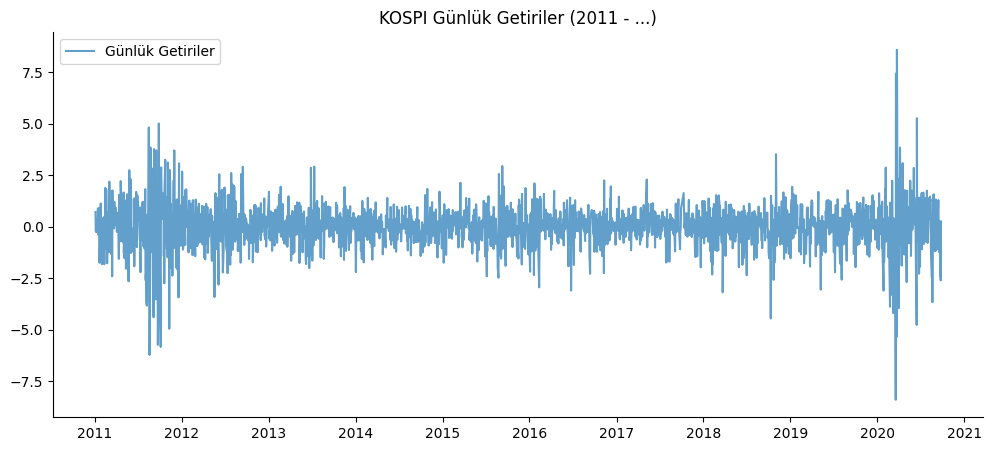


Son 365 gün için Rolling Tahmin yapılıyor (biraz sürebilir)...


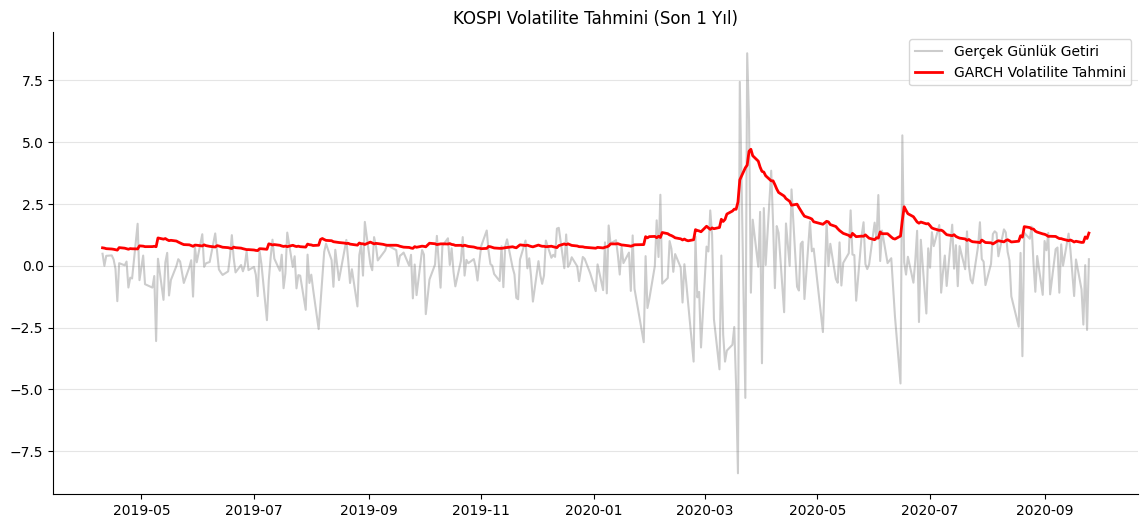

In [1]:
!pip install arch
from arch import arch_model
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

# 1. Veriyi Oku
url = "https://raw.githubusercontent.com/nurcoz/stock_denemeler/main/KOSPI_veri.csv"

# sep=None ve engine='python' Python'un virgül mü noktalı virgül mü olduğunu anlamasını sağlar
df = pd.read_csv(url, sep=None, engine='python')

# 2. Sütun İsimlerini Temizle (Olası boşlukları siler)
df.columns = df.columns.str.strip()

# 3. TARİH DÜZELTME (Kritik Adım)
# 14977 gibi sayıları 2011'li tarihlere çeviriyoruz
# unit='D' (Gün), origin='unix' (1970 bazlı)
df['Date'] = pd.to_datetime(df['Date'], unit='D', origin='unix')

# Tarihi index yap
df.set_index('Date', inplace=True)

print("Tarihler Düzeldi mi? İşte ilk 5 satır:")
print(df.head())
print("-" * 30)

# 4. Getiri Hesapla (Return)
# 'Close' sütununu kullanıyoruz
df['Return'] = 100 * (df['Close'].pct_change())
df.dropna(inplace=True)

# 5. Volatilite Tablosu
daily_vol = df['Return'].std()
monthly_vol = math.sqrt(21) * daily_vol
annual_vol = math.sqrt(252) * daily_vol

print(tabulate([['KOSPI', daily_vol, monthly_vol, annual_vol]],
               headers=['Günlük Vol %', 'Aylık Vol %', 'Yıllık Vol %'],
               tablefmt='fancy_grid', floatfmt=".2f"))

# 6. GARCH Modeli Eğitimi
print("\nModel Eğitiliyor...")
garch_model = arch_model(df['Return'], p=1, q=1, mean='constant', vol='GARCH', dist='normal')
gm_result = garch_model.fit(disp='off')
print(gm_result.summary())

# 7. Grafik Çizimi (Sonuçları Görelim)
fig, ax = plt.subplots(figsize=(12, 5))
ax.spines[['top','right']].set_visible(False)
plt.plot(df['Return'], label='Günlük Getiriler', alpha=0.7)
plt.title('KOSPI Günlük Getiriler (2011 - ...)')
plt.legend()
plt.show()

# 8. Rolling Forecast (Kayar Pencere Tahmini - Son 365 gün)
rolling_predictions = []
test_size = 365

print(f"\nSon {test_size} gün için Rolling Tahmin yapılıyor (biraz sürebilir)...")

for i in range(test_size):
    # Her adımda veriyi bir gün kaydırarak yeniden eğitiyoruz
    train = df['Return'][:-(test_size-i)]
    model = arch_model(train, p=1, q=1, mean='constant', vol='GARCH', dist='normal')
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

# Tahminleri Seriye Çevir
rolling_predictions = pd.Series(rolling_predictions, index=df['Return'].index[-test_size:])

# Tahmin Grafiği
fig, ax = plt.subplots(figsize=(14, 6))
ax.grid(which="major", axis='y', color='gray', alpha=0.2)
ax.spines[['top','right']].set_visible(False)

# Gerçek volatiliteyi temsilen getirileri çiziyoruz (arkada silik)
plt.plot(df['Return'][-test_size:], color='gray', alpha=0.4, label='Gerçek Günlük Getiri')
# Modelin tahmin ettiği volatilite (kırmızı çizgi)
plt.plot(rolling_predictions, color='red', linewidth=2, label='GARCH Volatilite Tahmini')

plt.title('KOSPI Volatilite Tahmini (Son 1 Yıl)')
plt.legend()
plt.show()

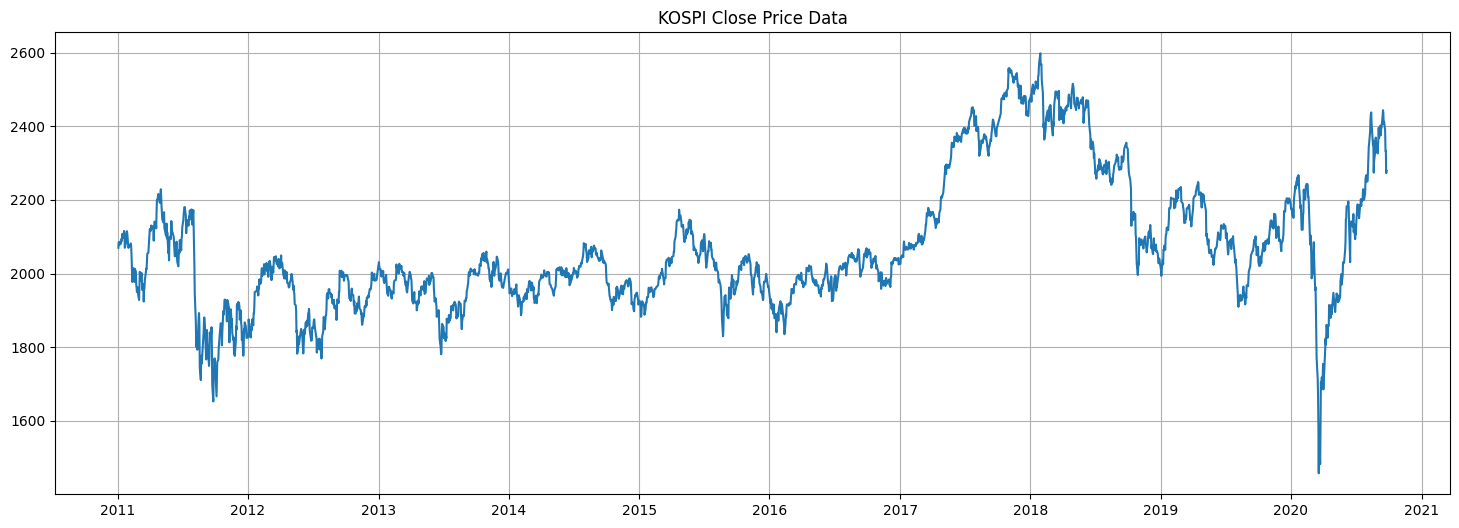

Orijinal Seri Analizi:


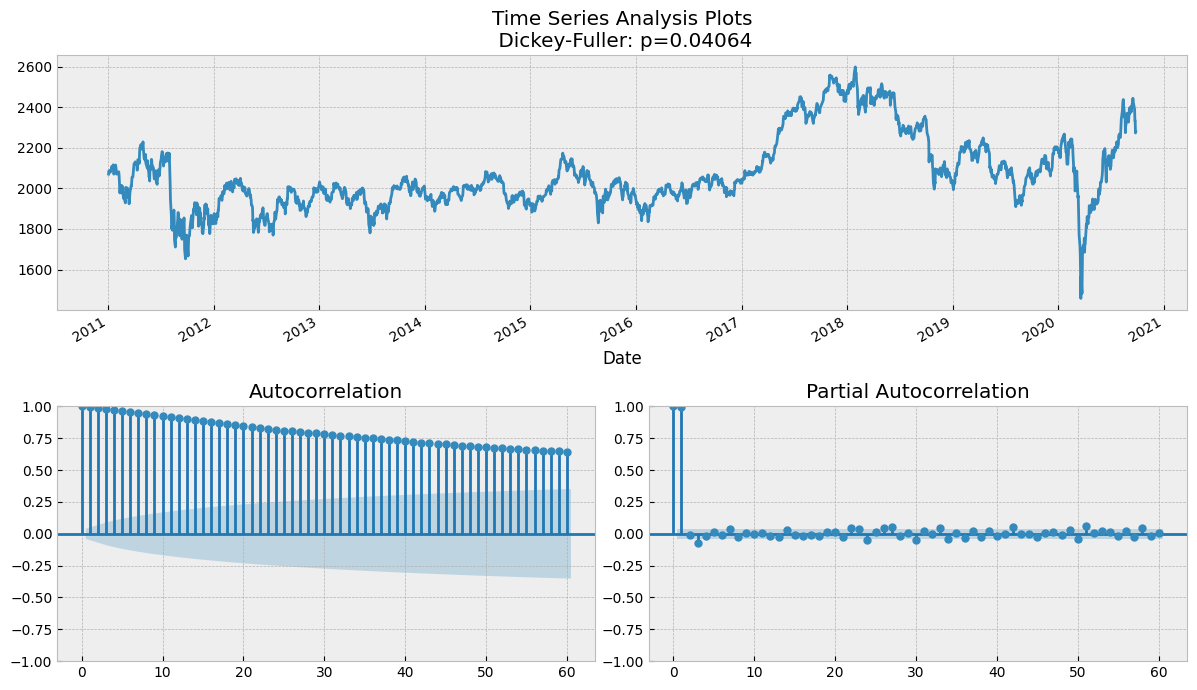

1. Dereceden Fark (Günlük Değişim) Analizi:


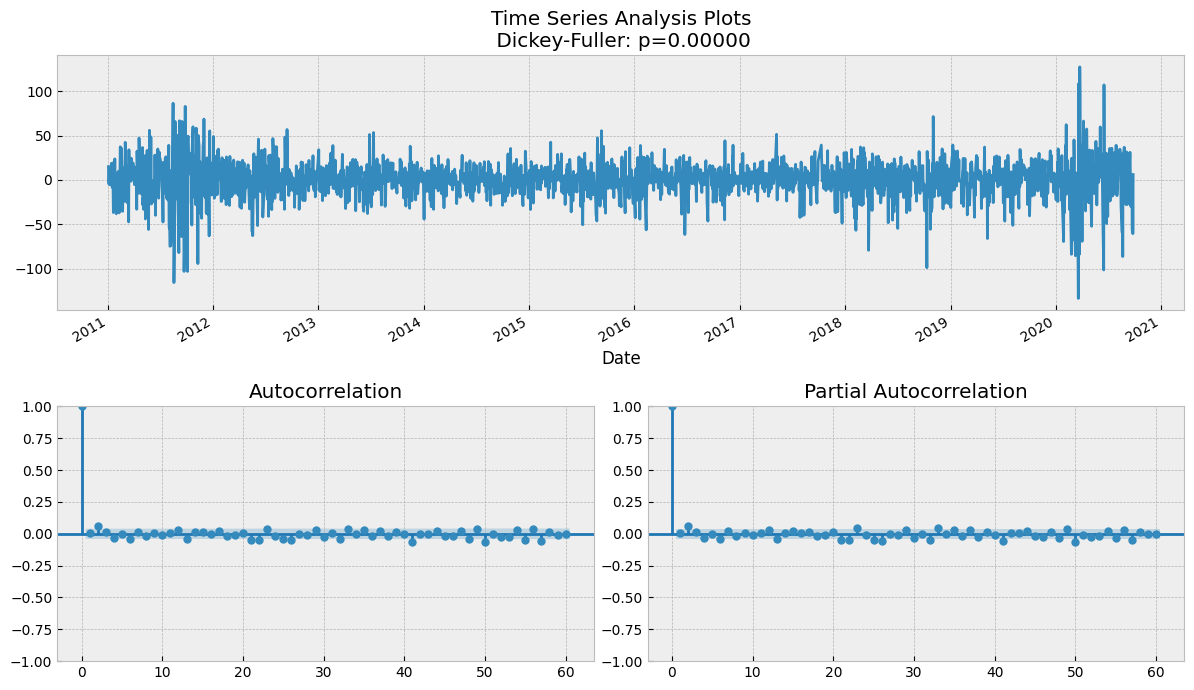

2. Dereceden Fark (Değişimin Değişimi) Analizi:


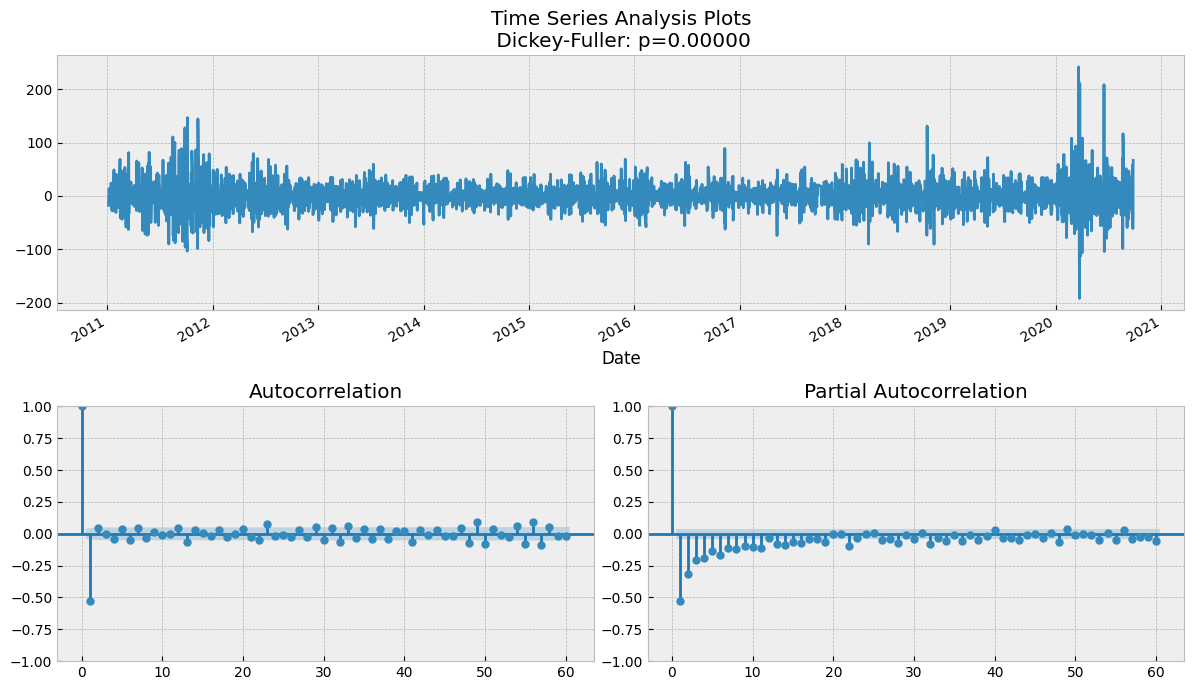

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Gerekli kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Yardımcı Fonksiyonlar ---

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
    Zaman serisi analizi için grafik çizer (TS, ACF, PACF)
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)

        # Dickey-Fuller Testi (Durağanlık kontrolü)
        # Not: Veri çok sabitse veya çok kısaysa hata verebilir, try-except ekledim.
        try:
            p_value = sm.tsa.stattools.adfuller(y)[1]
            ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        except:
            ts_ax.set_title('Time Series Analysis Plots\n (Dickey-Fuller hesaplanamadı)')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

# --- 1. Veriyi GitHub'dan Çekme ve Düzenleme ---

url = "https://raw.githubusercontent.com/nurcoz/stock_denemeler/main/KOSPI_veri.csv"

# Veriyi oku (separatör ve sütun sorunlarını düzelterek)
df = pd.read_csv(url, sep=None, engine='python')
df.columns = df.columns.str.strip()

# Tarih formatını düzeltme (Unix 14977 -> Datetime 2011...)
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], unit='D', origin='unix')
    df.set_index('Date', inplace=True)
else:
    print("HATA: Date sütunu bulunamadı.")

# Kapanış fiyatlarını alıyoruz
kospi_series = df['Close']

# --- 2. Analiz ve Görselleştirme ---

# A) Orijinal Veri Grafiği
plt.figure(figsize=(18, 6))
plt.plot(kospi_series)
plt.title('KOSPI Close Price Data')
plt.grid(True)
plt.show()

# B) Orijinal Veri için ACF/PACF ve Dickey-Fuller
# Orijinal fiyat serisi genelde durağan değildir (p-value yüksek çıkar)
print("Orijinal Seri Analizi:")
tsplot(kospi_series, lags=60)
plt.show()

# C) Fark Alma (Differencing) İşlemleri
# Hisse senetlerinde genelde 1. fark (günlük değişim) durağanlık sağlar.
# Orijinal kodda shift(24) vardı (saatlik veri için). Günlük veride shift(1) mantıklıdır.

# 1. Dereceden Fark (Günlük Değişim)
ads_diff = kospi_series - kospi_series.shift(1)
ads_diff.dropna(inplace=True)

print("1. Dereceden Fark (Günlük Değişim) Analizi:")
tsplot(ads_diff, lags=60)
plt.show()

# Eğer hala durağan değilse 2. kez fark alınabilir (Orijinal koddaki gibi)
# Not: Genelde finansal getirilerde 1. fark yeterlidir ama kodun akışına uyuyoruz.
ads_diff_2 = ads_diff - ads_diff.shift(1)
ads_diff_2.dropna(inplace=True)

print("2. Dereceden Fark (Değişimin Değişimi) Analizi:")
tsplot(ads_diff_2, lags=60)
plt.show()